In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from glob import glob
import pandas as pd
from subprocess import check_output
import os
# GOOGLE COLAB: device = torch.device('cuda') 

Directly load the train .jpg images:

In [30]:
basepath = 'sample_train_cervix_shapes/'
transform = transforms.Compose( [transforms.RandomResizedCrop(256),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# change from CIFAR: adding .ImageFolder (allows us to load images directly and allows us
    # to transform images!)
trainset_1 = datasets.ImageFolder(root=basepath,
                                           transform=transform)
    
# Some tensor info
#print('Tensor shape:', trainset_1.shape)   # t.size() gives the same
#print('Number of dimensions:', trainset_1.dim())
print('Tensor type:', type(trainset_1))  
# IMPORTANT: train_loader needs to take a TENSOR as input
train_loader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=4,
                                          shuffle=True, num_workers=2)
print(trainset_1)
print(type(train_loader_1))
### iterating through a loader to see what its data looks like: ###
# for i, (data, labels) in enumerate(train_loader):
#     print("i",i) --> starts at 0,  <class 'int'>
#     print("data ", data) --> feature tensor,  <class 'int'>
#     print("labels: ",labels) --> label tensor, <class 'list'>

Tensor type: <class 'torchvision.datasets.folder.ImageFolder'>
Dataset ImageFolder
    Number of datapoints: 60
    Root location: sample_train_cervix_shapes/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
<class 'torch.utils.data.dataloader.DataLoader'>


Load tensors instead of .jpg images in order to be able to preprocess data

In [31]:
### 1. Create dataframe where you have each image path, file type and label: ###
all_cervix_images = []

for path in sorted(glob(basepath + "*")): # iterate through each directory (ie each type)
    cervix_type = path.split("/")[-1] # gives you the type (ie directory) of current instance
    cervix_images = sorted(glob(basepath + cervix_type + "/*")) # gives you all images in current directory,
        # in the following format: sample_train_cervix_shapes/Type1/image_number.jpg
    all_cervix_images = all_cervix_images + cervix_images # list of all of the images in same format as previous!
    
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)

### 2. Convert the 'type' column info to floats so that it can then be put into tensors! ###
all_cervix_images.type[all_cervix_images.type == 'Type1'] = 1
all_cervix_images.type[all_cervix_images.type == 'Type2'] = 2
all_cervix_images.type[all_cervix_images.type == 'Type3'] = 3
all_cervix_images.head()

,imagepath,filetype,type
0,sample_train_cervix_shapes/Type1/191.jpg,jpg,1
1,sample_train_cervix_shapes/Type1/201.jpg,jpg,1
2,sample_train_cervix_shapes/Type1/205.jpg,jpg,1
3,sample_train_cervix_shapes/Type1/208.jpg,jpg,1
4,sample_train_cervix_shapes/Type1/215.jpg,jpg,1


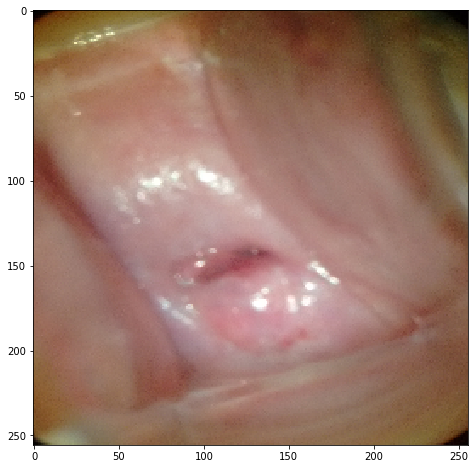

In [33]:
### 3. create feature tensor for each image ###

def get_image_data(image_path):
    """
    Method to get image data as np.array specifying image id and type
    """
    #fname = get_filename(image_id, image_type)
        # fname = sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg
    img = cv2.imread(image_path)
        # cv2.imread(sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg)
    #assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def transform_image(img, rescaled_dim_x, rescaled_dim_y, to_gray=False):
    resized = cv2.resize(img, (rescaled_dim_x, rescaled_dim_y), cv2.INTER_LINEAR)
    
    if to_gray:
        resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY).astype('float')
   # else:
    #    resized = resized.astype('float')
    '''  
    if normalized:
        resized = cv2.normalize(resized, None, 0.0, 1.0, cv2.NORM_MINMAX)
        timg = resized.reshape(1, np.prod(resized.shape))
        # return timg/np.linalg.norm(timg)
    ''' 
    return resized

fig = plt.figure(figsize=(12,8))

### generic method ###
plt.imshow(plt.imread('sample_train_cervix_shapes/Type1/191.jpg'))
plt.imshow(transform_image(plt.imread('sample_train_cervix_shapes/Type2/31.jpg'),256, 256))

In [ ]:
def sieve(image, size):
    """
    Filter removes small objects of 'size' from binary image
    Input image should be a single band image of type np.uint8
    Idea : use Opencv findContours
    """
    sqLimit = size**2
    linLimit = size*4
    outImage = image.copy()
    image, contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(hierarchy) > 0:
        hierarchy = hierarchy[0]
        index = 0
        while index >= 0:
            contour = contours[index]
            p = cv2.arcLength(contour, True)
            s = cv2.contourArea(contour)
            r = cv2.boundingRect(contour)
            if s <= sqLimit and p <= linLimit:
                outImage[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = 0
            index = hierarchy[index][0]
    else:
        pass
        # print("No contours found")
    return outImage


# in HSV :
skin_range_1_min = np.array([120, 0, 0], dtype=np.uint8)
skin_range_1_max = np.array([255, 255, 255], dtype=np.uint8)

skin_range_2_min = np.array([0, 0, 0], dtype=np.uint8)
skin_range_2_max = np.array([45, 255, 255], dtype=np.uint8)

skin_kernel_size = 7
skin_sieve_min_size = 5

def detect_skin(image):
    proc = cv2.medianBlur(image, 7)
    ### Detect skin
    image_hsv = cv2.cvtColor(proc, cv2.COLOR_RGB2HSV)
    skin_like_mask = cv2.inRange(image_hsv, skin_range_1_min, skin_range_1_max)
    skin_like_mask_2 = cv2.inRange(image_hsv, skin_range_2_min, skin_range_2_max)
    skin_like_mask = cv2.bitwise_or(skin_like_mask, skin_like_mask_2)    
    # Filter the skin mask :
    skin_mask = sieve(skin_like_mask, skin_sieve_min_size)
    kernel = np.ones((skin_kernel_size, skin_kernel_size), dtype=np.int8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)    
    # Apply skin mask
    skin_segm_rgb = cv2.bitwise_and(image, image, mask=skin_mask)
    return skin_segm_rgb

for image in [img_1, img_2, img_3, img_4, img_5]:       
    image = cv2.resize(image, dsize=(512, 512))
    skin_segm_rgb = detect_skin(image)
    plt_st(12, 4)
    plt.subplot(121)
    plt.title("Original image")    
    plt.imshow(image)
    plt.subplot(122)
    plt.title("Skin segmentation")
    plt.imshow(skin_segm_rgb)

In [7]:
complete_images = []
import glob
import os.path
from os import path
import torch
for file in list(glob.glob('sample_train_cervix_shapes/Type*/*')):
    ### get the label of each instance and make it into a tensor
    if file.find("Type1")!= -1:
        label = torch.tensor([1])
    if file.find("Type2")!= -1:
        label = torch.tensor([2])
    if file.find("Type3")!= -1:
        label = torch.tensor([3])
    # print("label: ",label)
    # print("label tyle: ",type(label))
    
    ### get feature tensor of each instance resize, normalize and convert np.array to tesor
    complete_image = get_image_data(file)
    complete_image = transform_image(complete_image, 256, 256, normalized=True) # <class 'numpy.ndarray'>
    complete_image = torch.from_numpy(complete_image) # <class 'torch.Tensor'>
    
    # Some tensor info
    print('Tensor shape:', complete_image.shape)   # t.size() gives the same
    print('Number of dimensions:', complete_image.dim())
    print('Tensor type:', complete_image.type())  
    print('Label Tensor shape:', label.shape)   # t.size() gives the same
    print('Label Number of dimensions:', label.dim())
    print('Label Tensor type:', label.type())  
    
    #print(complete_image.shape)
    complete_image = torch.cat((complete_image, label),dim=0)
    print('Tensor shape2:', complete_image.shape) 
    #print("type: ",type(complete_image))
    #print("complete image: ",complete_image)
    #complete_images.append(complete_image)

Tensor shape: torch.Size([256, 256, 3])
Number of dimensions: 3
Tensor type: torch.DoubleTensor
Label Tensor shape: torch.Size([1])
Label Number of dimensions: 1
Label Tensor type: torch.LongTensor


RuntimeError: Expected object of scalar type double but got scalar type long long for sequence element 1.

In [5]:
#type(complete_images)
#type(complete_images)
#complete_images = np.asarray(complete_images)
#type(all_cervix_images['type'])
#import tensorflow as tf
#complete_images = tf.convert_to_tensor(complete_images)
#type(complete_images)
#torch.tensor(complete_images)
#labels_tensor = torch.tensor(all_cervix_images['type'])
#type(labels_tensor)
#trainset_2 = torch.cat([complete_images,labels_tensor],1)

#labels = all_cervix_images['type']
#print(type(complete_images))
#print(type(labels))
train_loader = torch.utils.data.DataLoader(complete_images, batch_size=4,shuffle=True, num_workers=2)

In [6]:
train_loader.dataset
#labels_tensor = torch.tensor(all_cervix_images['type'])
#trainset = torch.cat([images_tensor,labels_tensor],1)
#train_loader1 = torch.utils.data.DataLoader(trainset2, batch_size=4,
 #                                         shuffle=True, num_workers=2)


#for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    #print(data)
#     inputs, labels = data
   # print(inputs)
#labels = all_cervix_images['type']
#print(labels)

[array([0.17670683, 0.15261044, 0.19277108, ..., 0.37751004, 0.37751004,
        1.        ]),
 array([0.47058824, 0.45098039, 0.60784314, ..., 0.38039216, 0.35686275,
        1.        ]),
 array([0.19211823, 0.13300493, 0.22167488, ..., 0.27586207, 0.44334975,
        1.        ]),
 array([0.59349593, 0.32520325, 0.3902439 , ..., 0.29268293, 0.38617886,
        1.        ]),
 array([0.02352941, 0.00784314, 0.00392157, ..., 0.        , 0.01568627,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.15853659, 0.19512195,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.01568627, 0.01176471,
        1.        ]),
 array([0.36507937, 0.28571429, 0.27777778, ..., 0.03968254, 0.07936508,
        1.        ]),
 array([0.02352941, 0.01568627, 0.02745098, ..., 0.00392157, 0.02352941,
        1.        ]),
 array([0.01960784, 0.01176471, 0.05098039, ..., 0.02352941, 0.05490196,
        1.        ]),
 array([0.        , 0.00392157, 0.01176471, ..., 0

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):

    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(in_channels=7, out_channels=16, kernel_size=5)
    self.linear1 = nn.Linear(61 * 61 * 7, 128) # 196608
    self.linear2 = nn.Linear(128, 1)

  def forward(self, x):

    # convolution layers
    
    # input size: 256 x 256 x 3; output size: 252 x 252 x 7
    # pooling output: 126 x 126 x 7
    x = self.pool(F.relu(self.conv1(x)))
    
    # input size: 126 x 126 x 7; output size: 122 x 122 x 7
    # pooling output: 61 x 61 x 7
    x = self.pool(F.relu(self.conv2(x)))
    
    # linear layer
    x = x.view(-1, 61 * 61 * 7) # flatten for linear layers
    x = F.relu(self.linear1(x))
    x = F.softmax(self.linear2(x), dim=1)
    
    return x

# create network depending on hardware available
#if use_gpu:
 # net = Net().cuda()

#else:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    batch_size = 4
    for i, data in enumerate(train_loader, 0):
        labels = []
        inputs = []
        for j in range(batch_size):
            labels.append(data[j,-1])
        for j in range(batch_size):
            inputs.append(data[j,0:-1])
            
        ### safety check: ###
            # print("len data",len(data[0]))
            # print("len inputs",len(inputs[0]))
            # len inputs = len data - 1 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        '''
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        '''
print('Finished Training')

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list